# 치아 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os
from PIL import Image

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import f1_score

import wandb

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

In [3]:
wandb.login(key='')
run = wandb.init(project='cv_79_part2_6', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin


# CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_path, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.ipynb_checkpoints' and img != '.DS_Store':
                    img_path = os.path.join(cls_path, img)
                    self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [5]:
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])
classes = ['calculus', 'caries', 'discoloration', 'hypodontia', 'ulcers']

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/6/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/6/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/6/data/test', classes, transforms)

In [6]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

2410 547 312


In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 32, shuffle=False)

# Train, Eval

In [8]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    total_labels = []
    total_preds = []
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_accuracy, train_f1

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_accuracy, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy, train_f1 = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy, valid_f1 = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring = {'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Train F1': train_f1,
                      'Valid Loss': valid_loss, 'Valid Accuracy': valid_accuracy, 'Valid F1': valid_f1}
        run.log(monitoring, step=epoch)

    return model

# model

In [9]:
model = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes = len(classes)
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [10]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 30)

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [12]:
run.finish()

Train Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
Train F1,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
Train Loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Accuracy,▁▂▃▃▄▄▅▅▅▅▅▅▆▆▅▆▇▆▆▇▇▆▇▇▇█▇▆▇▆
Valid F1,▁▂▃▂▃▄▄▄▅▄▅▅▅▆▅▆▇▆▆▆▇▆▇▇▇█▇▇▇▇
Valid Loss,█▆▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂
Train Accuracy,0.88838
Train F1,0.83218
Train Loss,0.33511
Valid Accuracy,0.5521
Valid F1,0.4546


# Test

In [13]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
f1_score(total_labels, total_preds, average='macro')

0.624340369157871

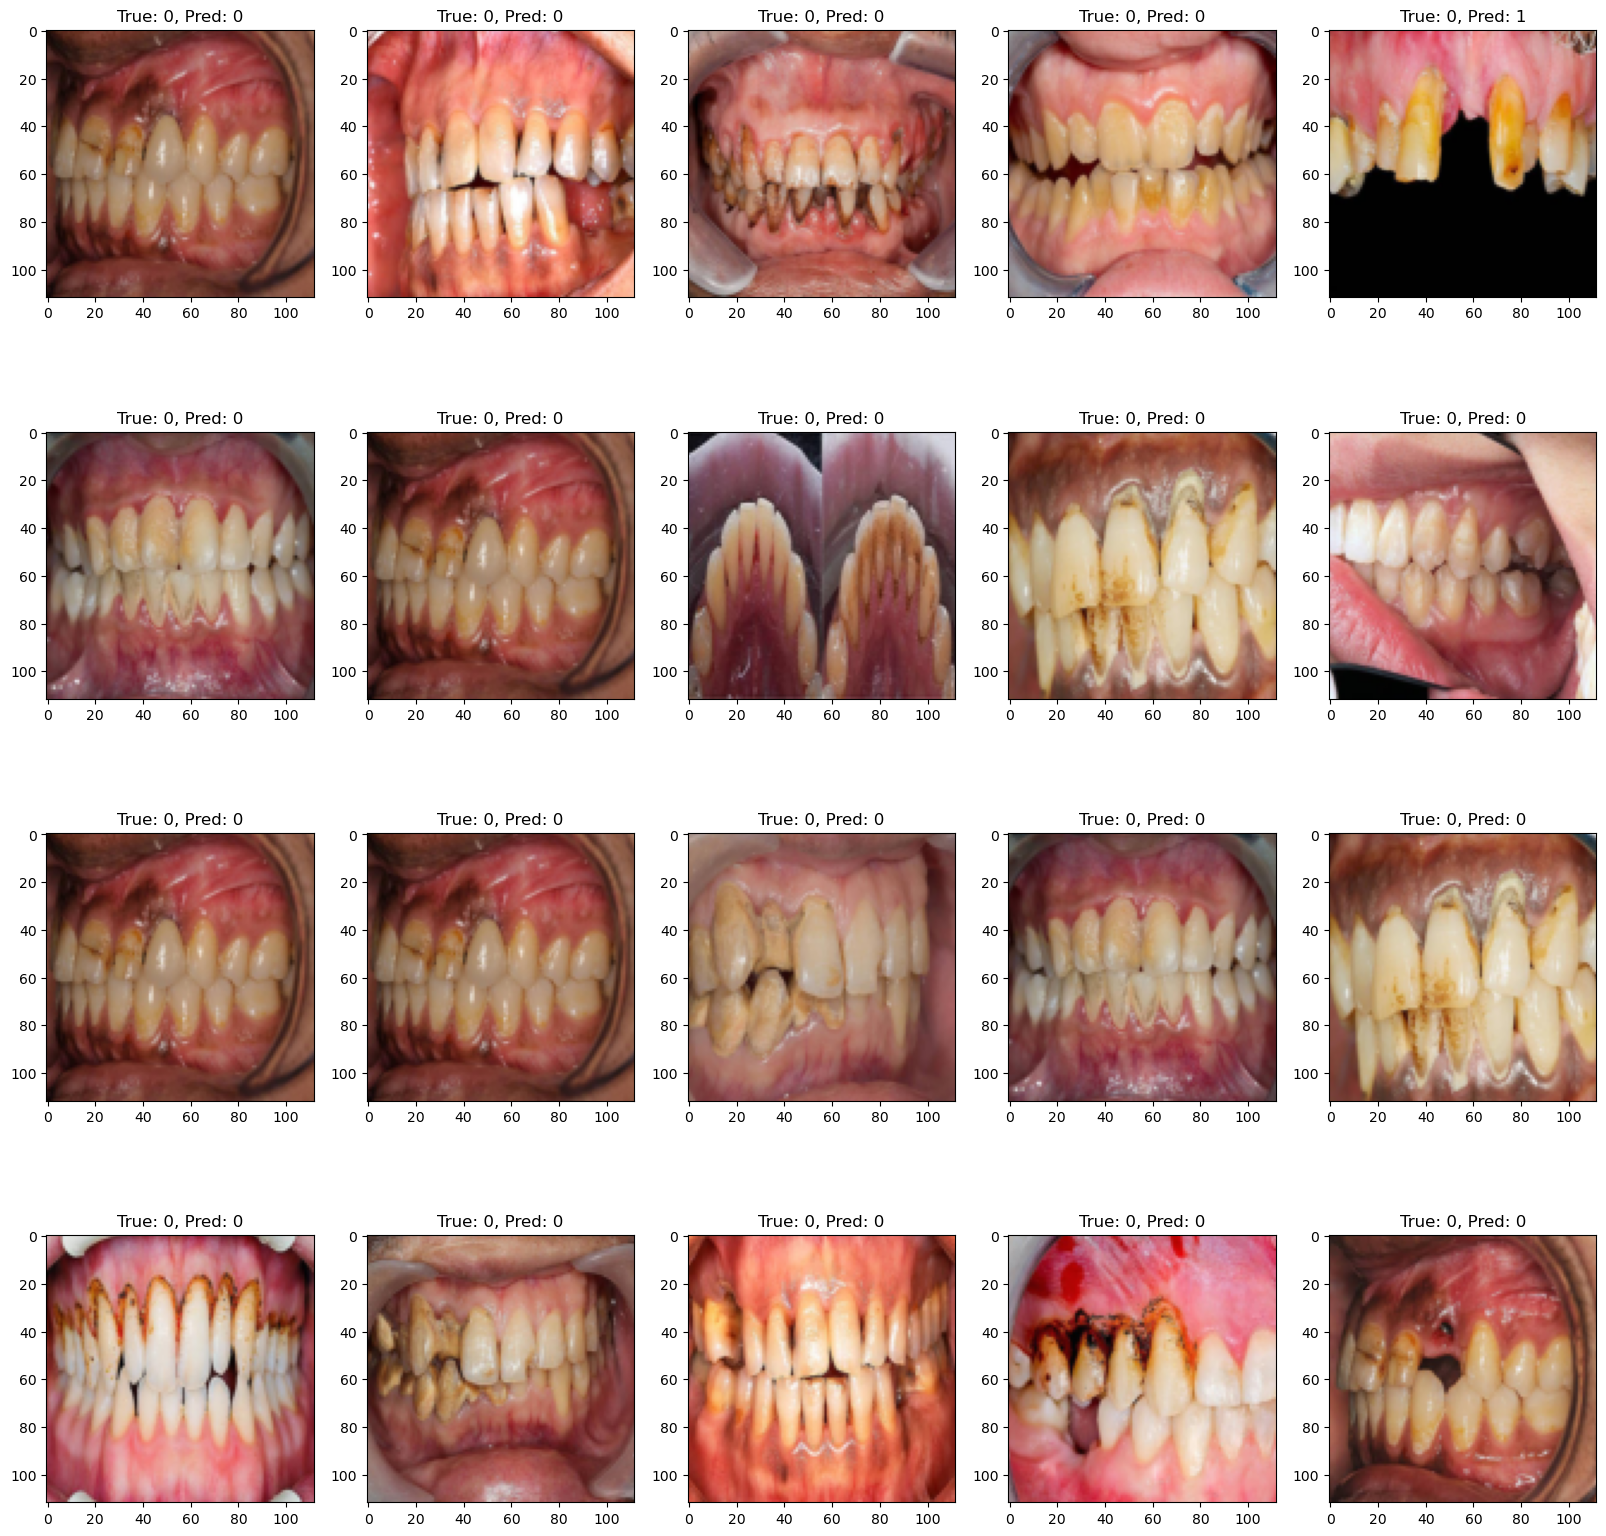

In [15]:
plt.figure(figsize=(20, 20))

for i in range(5, 25):
    ax = plt.subplot(4, 5, i-5+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}, Pred: {total_preds[i]}')